#### In this notebook we will be implementing the convolutional autoencoder, which simply means we will be using CNN layers instead of fully connected dense layers.


In [21]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

In [22]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [23]:
# set up the transformations required for the training and testing data
# convert to tensor, normalize and move to cuda
image_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize([0.5], [0.5]),transforms.Lambda(lambda x : x.to(device))
])

In [24]:
# Creating training and testing datasets
train_dataset = MNIST(root='./MnistDataset', train=True, transform=image_transform, download=True)
validation_dataset = MNIST(root='./MnistDataset', train=False, transform=image_transform, download=True)

In [25]:
# Set up the dataloaders
from torch.utils.data import DataLoader
batch_size = 128

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=1) 
        )
        
        # define the decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16,kernel_size=5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [27]:
from torchsummary import summary
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 128, 3, 3]           36,992
|    └─ReLU: 2-5                         [-1, 128, 3, 3]           --
|    └─MaxPool2d: 2-6                    [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            36,896
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 128, 3, 3]           36,992
|    └─ReLU: 2-5                         [-1, 128, 3, 3]           --
|    └─MaxPool2d: 2-6                    [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            36,896
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [28]:
# Training batch
def trainBatch(input, model, criterion, optimiser):
    model.train()
    optimiser.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimiser.step()
    return loss

In [29]:
# validation batch
@torch.no_grad()
def validBatch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [30]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

EPOCH: 0.019  trn_loss: 0.978  (0.10s - 50.89s remaining)

EPOCH: 1.000  val_loss: 0.127  trn_loss: 0.347  (5.44s - 48.92s remaining)
EPOCH: 2.000  val_loss: 0.078  trn_loss: 0.096  (10.71s - 42.83s remaining)
EPOCH: 3.000  val_loss: 0.066  trn_loss: 0.073  (15.97s - 37.27s remaining)
EPOCH: 4.000  val_loss: 0.059  trn_loss: 0.064  (21.22s - 31.82s remaining)
EPOCH: 5.000  val_loss: 0.054  trn_loss: 0.058  (26.46s - 26.46s remaining)
EPOCH: 6.000  val_loss: 0.051  trn_loss: 0.054  (31.71s - 21.14s remaining)
EPOCH: 7.000  val_loss: 0.049  trn_loss: 0.051  (36.99s - 15.85s remaining)
EPOCH: 8.000  val_loss: 0.047  trn_loss: 0.049  (42.28s - 10.57s remaining)
EPOCH: 9.000  val_loss: 0.046  trn_loss: 0.047  (47.59s - 5.29s remaining)
EPOCH: 10.000  val_loss: 0.044  trn_loss: 0.046  (52.84s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 3151.43it/s]


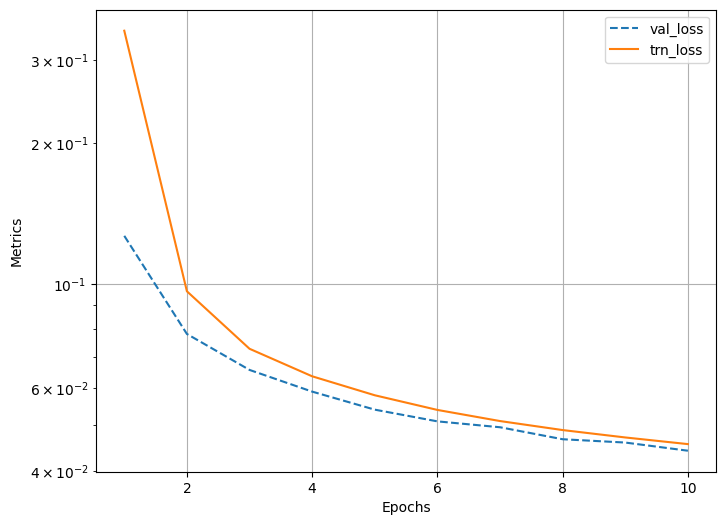

In [31]:
# Train model over increasing epochs
numEpochs = 10

# report
from torch_snippets import Report
log = Report(numEpochs)

for epoch in range(numEpochs):
    N = len(trainLoader)
    
    for index,(image,label) in enumerate(trainLoader):
        loss = trainBatch(image, model, criterion, optimiser)
        log.record(pos=(epoch + (index+1)/N), trn_loss=loss,end = '\r')
    
    N = len(validationLoader)
    for index,(image,label) in enumerate(validationLoader):
        loss = validBatch(image, model, criterion)
        log.record(pos=(epoch + (index+1)/N), val_loss=loss,end = '\r')
    
    log.report_avgs(epoch+1)
log.plot_epochs(log=True)

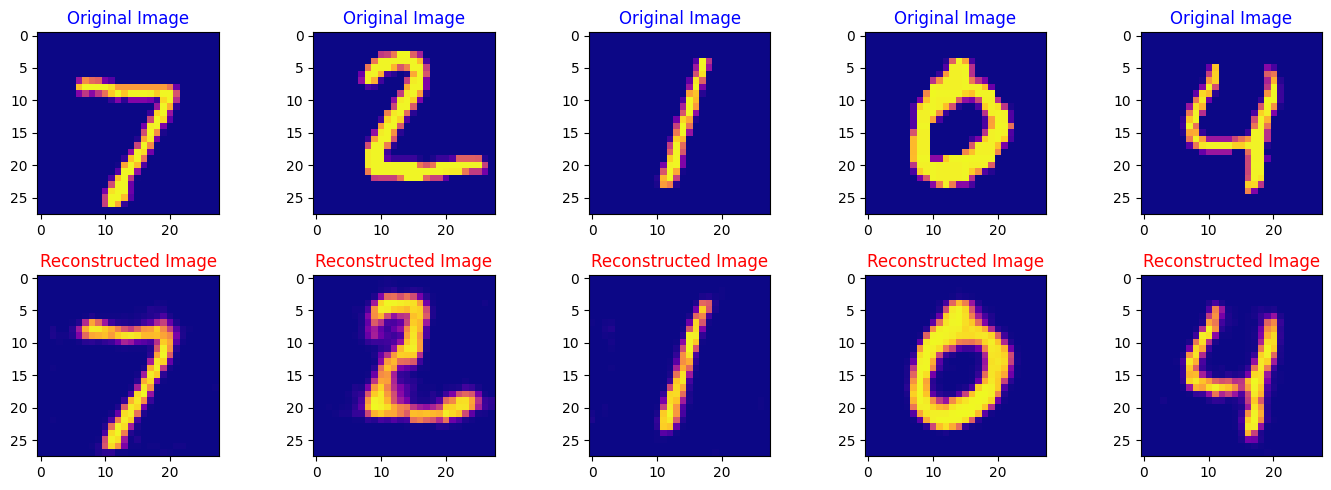

In [32]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 5 columns, transposed
fig, axs = plt.subplots(2, 5, figsize=(14, 5))

# Iterate over 5 images in the validation set
for i in range(5):
    # Get the i-th image and send it to the device
    image, _ = validation_dataset[i]
    image = image.unsqueeze(0).to(device)
    
    # Generate the output using the model
    output = model(image)
    
    # Plot the original image
    axs[0, i].imshow(image.cpu().numpy().squeeze(), cmap='plasma')
    axs[0, i].set_title('Original Image', fontsize=12, color='blue')
    
    # Plot the reconstructed image
    axs[1, i].imshow(output.cpu().detach().numpy().squeeze(), cmap='plasma')
    axs[1, i].set_title('Reconstructed Image', fontsize=12, color='red')

# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
